<a href="https://colab.research.google.com/github/carla-biermann/uniform-solution-sampling/blob/main/notebooks/Uniformity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# @title Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import random
import scipy

In [2]:
# @title Load XOR data
df_xor = pd.read_csv('https://raw.githubusercontent.com/chrissuthy/designCP/carla_cp/experiment/results/solutions_xor.csv', )

df_xor.drop('Unnamed: 0', axis=1, inplace=True)
df_xor.head()

,s,iteration,solution,num sols
0,0,8,"[1, 2, 4, 5, 7, 10]",22
1,0,12,"[1, 4, 5, 6, 7, 10]",22
2,0,20,"[1, 3, 4, 5, 6, 8]",22
3,0,21,NaN,0
4,0,23,"[1, 3, 4, 5, 7, 8]",22


### Replace solutions where s=0. Something went wrong in the script.

In [3]:
# Get unique solutions
zero_s_rows = df_xor[(df_xor['s'] == 0) & (df_xor['num sols'] != 0)]
unique_sols = zero_s_rows['solution'].unique()
len_zero_s_rows = len(zero_s_rows)
print(f'Number of rows to replace: {len_zero_s_rows}')

Number of rows to replace: 2179


In [4]:
# drop all rows where 's' = 0 and that contain a solution
print(f'Previous length of dataframe: {len(df_xor)}')
df_xor = df_xor[(df_xor['s'] != 0)]
print(f'New length of dataframe: {len(df_xor)}')

Previous length of dataframe: 13180
New length of dataframe: 11000


In [5]:
# Replace dropped rows by random sample of solutions (= uniform sampling)
sample = random.choices(unique_sols, k=len_zero_s_rows)

new_data = {'s': [0] * len_zero_s_rows, 'iteration': list(range(1, len_zero_s_rows + 1)),'solution': sample, 'num sols': [22] * len_zero_s_rows}

df_xor = df_xor.append(pd.DataFrame(new_data))

df_xor = df_xor.sort_values(by=['s', 'iteration'])

print(f'New length of dataframe: {len(df_xor)}')

New length of dataframe: 13179


<ipython-input-5-60dc2e1f0637>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_xor = df_xor.append(pd.DataFrame(new_data))


In [6]:
df_xor.head()

,s,iteration,solution,num sols
0,0,1,"[1, 2, 4, 5, 7, 9]",22
1,0,2,"[1, 3, 4, 5, 6, 7]",22
2,0,3,"[1, 2, 4, 5, 7, 8]",22
3,0,4,"[1, 3, 4, 5, 7, 10]",22
4,0,5,"[1, 4, 5, 6, 7, 10]",22


### LinMod Data

In [7]:
# @title Load LinMod data
df_linmod = pd.read_csv("https://raw.githubusercontent.com/chrissuthy/designCP/carla_cp/experiment/results/solutions_linmod.csv")

df_linmod.drop('Unnamed: 0', axis=1, inplace=True)
df_linmod.head()

,lambda,iteration,solution,num sols
0,0.02,15,NaN,0
1,0.02,16,"[1, 3, 4, 5, 6, 9]",1
2,0.02,21,NaN,0
3,0.02,22,NaN,0
4,0.02,23,"[1, 4, 5, 6, 7, 9]",1


In [8]:
# @title Load LinMod adjusted data
df_linmod_adj = pd.read_csv("https://raw.githubusercontent.com/chrissuthy/designCP/carla_cp/experiment/results/solutions_linmod_adjusted.csv")

df_linmod_adj.drop('Unnamed: 0', axis=1, inplace=True)
df_linmod_adj.head()

,lambda,iteration,solution,num sols
0,0.02,15,NaN,0
1,0.02,16,"[1, 3, 4, 5, 6, 9]",1
2,0.02,21,NaN,0
3,0.02,22,NaN,0
4,0.02,23,"[1, 4, 5, 6, 7, 9]",1


### Define functions for goodness of fit tests

In [9]:
# Function to apply chi-square test to each row
def chi2_test(row, k):
    observed = row
    expected = sum(observed) / k * np.ones_like(observed)  # Assuming uniform distribution

    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed - expected)**2 / expected)

    # Calculate p-value
    p_value = 1 - scipy.stats.chi2.cdf(chi_squared_stat, df=k-1)

    return p_value

# Function to apply the freeman tukey test to each row
def freeman_tukey_test(row, k):
    observed = row
    expected = sum(observed) / k * np.ones_like(observed)  # Assuming uniform distribution

    ft_stat = np.sum((np.sqrt(observed) + np.sqrt(observed + 1) - np.sqrt(4 * expected + 1))**2)

    # Calculate p-value

    p_value = 1 - scipy.stats.chi2.cdf(ft_stat, df=k-1)

    return p_value

# Function to apply the Kolmogorov-Smirnov test to each row
def ks_test(row, k):
    # Perform KS test
    ks_statistic, p_value = scipy.stats.ks_1samp(row, scipy.stats.randint.cdf, args=(1, k+1))
    return p_value

def cramer_von_mises_test(row, k):
    observed = row
    expected = sum(observed) / k * np.ones_like(observed)
    n = sum(observed)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    Z = S - T
    W2_statistic = sum(Z**2 * (1/k)) / n
    percentage_point = 0.463 # from paper
    if W2_statistic > percentage_point:
      return 0
    else:
      return 1

def watson_test(row, k):
    observed = row
    expected = sum(observed) / k * np.ones_like(observed)
    n = sum(observed)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    Z = S - T
    Z_bar = sum(Z / k)
    U2_statistic = sum((Z - Z_bar)**2 * (1/k)) / n
    percentage_point = 0.191 # from paper
    if U2_statistic > percentage_point:
      return 0
    else:
      return 1

def anderson_darling_test(row, k):
    observed = row
    expected = sum(observed) / k * np.ones_like(observed)
    n = sum(observed)
    S = np.cumsum(observed)
    T = np.cumsum(expected)
    H = T / n
    Z = S - T
    # remove last elements as they would result in 0/0 and author sets term to 0
    Z = Z[:-1]
    H = H[:-1]
    A2_statistic = sum(Z**2 * (1/k) / (H*(1-H))) / n
    percentage_point = 2.392 # from paper
    if A2_statistic > percentage_point:
      return 0
    else:
      return 1

# Function to resample from the data
def resample(df, sample_size, param):
    samples_df = pd.DataFrame(columns = [param, 'solution', 'num sols'])

    df_no_na = df.dropna()

    # Group by 's' column and sample within each group
    for group, group_df in df_no_na.groupby(param):
        num_samples = len(group_df) / sample_size
        group_sample = group_df[[param, 'solution', 'num sols']].sample(n=sample_size, replace=False)
        samples_df = pd.concat([samples_df, group_sample])

    return(samples_df)

# Function to get p values
def get_p_values(sample_size, iterations, k, tests, param, df):

  random.seed(40)

  # stores p values for all param for each iteration i
  dfs_list = []
  for test in tests:
     dfs_list.append(pd.DataFrame(columns=list(df[param].unique())))

  for i in range(iterations):

    # sample of size sample_size for each s (concatenated)
    sample = resample(df, sample_size, param)

    # get counts for each solution per param
    sample_counts = sample.groupby(param)['solution'].value_counts().unstack()

    sample_counts.fillna(0, inplace=True)

    sample_counts_arr = sample_counts.to_numpy()

    for j, test in enumerate(tests):

      # apply test to samples and obtain one p-value per s in an array
      p_vals = np.apply_along_axis(test, axis=1, arr=sample_counts_arr, k=k)

      # store whether p value is significant or now
      new_row = p_vals < 0.05

      dfs_list[j].loc[len(dfs_list[j])] = new_row

  return dfs_list

## Histograms

In [10]:
# Group by 's' and obtain value counts for each group in the 'solution' column
group_value_counts = df_xor.groupby('s')['solution'].value_counts().unstack()
group_value_counts

solution,"[1, 2, 4, 5, 7, 10]","[1, 2, 4, 5, 7, 8]","[1, 2, 4, 5, 7, 9]","[1, 3, 4, 5, 6, 10]","[1, 3, 4, 5, 6, 7]","[1, 3, 4, 5, 6, 8]","[1, 3, 4, 5, 6, 9]","[1, 3, 4, 5, 7, 10]","[1, 3, 4, 5, 7, 8]","[1, 3, 4, 5, 7, 9]",...,"[1, 3, 4, 6, 7, 9]","[1, 3, 5, 6, 7, 10]","[1, 3, 5, 6, 7, 8]","[1, 3, 5, 6, 7, 9]","[1, 4, 5, 6, 7, 10]","[1, 4, 5, 6, 7, 8]","[1, 4, 5, 6, 7, 9]","[3, 4, 5, 6, 7, 10]","[3, 4, 5, 6, 7, 8]","[3, 4, 5, 6, 7, 9]"
s,,,,,,,,,,,,,,,,,,,,,
0,100,81,107,98,116,93,98,102,105,87,...,95,87,94,112,98,114,96,95,96,109
1,110,109,88,107,95,96,101,102,106,114,...,101,84,83,99,95,104,93,95,91,110
2,103,90,95,106,119,95,96,109,85,105,...,111,95,90,112,94,88,94,103,98,83
3,100,97,94,91,90,86,102,93,98,100,...,83,84,74,99,105,109,94,101,99,91
4,75,80,86,84,79,83,86,75,58,68,...,71,73,78,81,76,68,80,73,77,74
5,40,42,50,53,63,47,48,46,41,49,...,59,48,34,64,56,44,46,49,47,55


In [11]:
group_value_counts_linmod = df_linmod.groupby('lambda')['solution'].value_counts().unstack()
group_value_counts_linmod

solution,"[1, 2, 4, 5, 7, 10]","[1, 2, 4, 5, 7, 8]","[1, 2, 4, 5, 7, 9]","[1, 3, 4, 5, 6, 10]","[1, 3, 4, 5, 6, 7]","[1, 3, 4, 5, 6, 8]","[1, 3, 4, 5, 6, 9]","[1, 3, 4, 5, 7, 10]","[1, 3, 4, 5, 7, 8]","[1, 3, 4, 5, 7, 9]",...,"[1, 3, 4, 6, 7, 9]","[1, 3, 5, 6, 7, 10]","[1, 3, 5, 6, 7, 8]","[1, 3, 5, 6, 7, 9]","[1, 4, 5, 6, 7, 10]","[1, 4, 5, 6, 7, 8]","[1, 4, 5, 6, 7, 9]","[3, 4, 5, 6, 7, 10]","[3, 4, 5, 6, 7, 8]","[3, 4, 5, 6, 7, 9]"
lambda,,,,,,,,,,,,,,,,,,,,,
0.02,25,25,27,26,32,26,28,37,29,29,...,26,28,25,36,33,26,32,29,34,27
0.03,31,50,39,30,40,38,41,28,34,29,...,40,26,36,41,36,25,45,42,36,32
0.04,42,35,34,36,48,50,28,33,45,36,...,55,37,42,42,41,33,38,40,32,33
0.05,27,35,46,35,46,39,31,44,45,38,...,31,31,27,33,40,44,44,32,39,32
0.06,39,36,30,35,29,33,38,40,34,34,...,29,44,30,35,40,36,37,24,31,38
0.07,29,38,34,35,41,32,34,38,30,39,...,28,32,43,34,36,25,34,35,33,32
0.08,23,20,27,32,28,29,30,29,26,22,...,26,26,27,29,31,30,25,34,18,21
0.09,12,26,12,25,28,32,34,15,24,22,...,22,25,27,18,15,28,19,17,15,30


In [12]:
# @title Histogram plot function

def plot_hists(data):
  fig, axes = plt.subplots(nrows=len(data), ncols=1, figsize=(8, 6 * len(data)))

  for i, (group, counts) in enumerate(data.iterrows()):
      ax = axes[i]
      ax.bar(counts.index, counts.values, alpha=0.7)
      ax.set_title(f'Histogram for {group} constraints')
      ax.set_xlabel('Solutions')
      ax.set_ylabel('Frequency')

  plt.show()

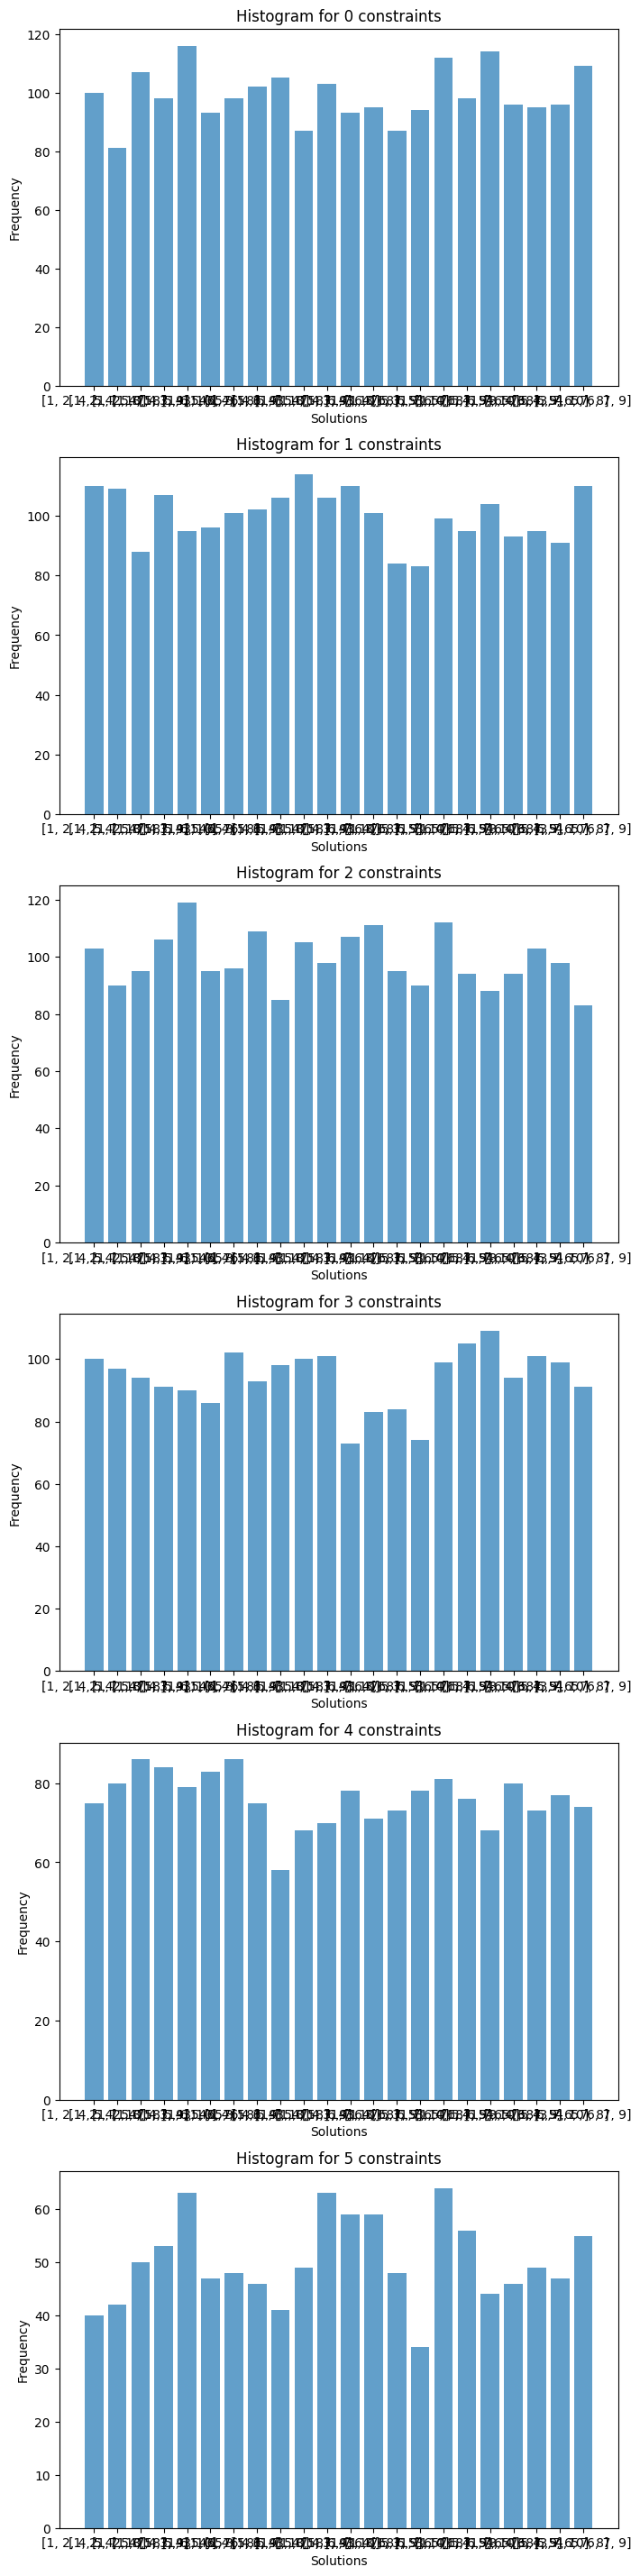

In [13]:
# @title Plot histograms for each s
plot_hists(group_value_counts)

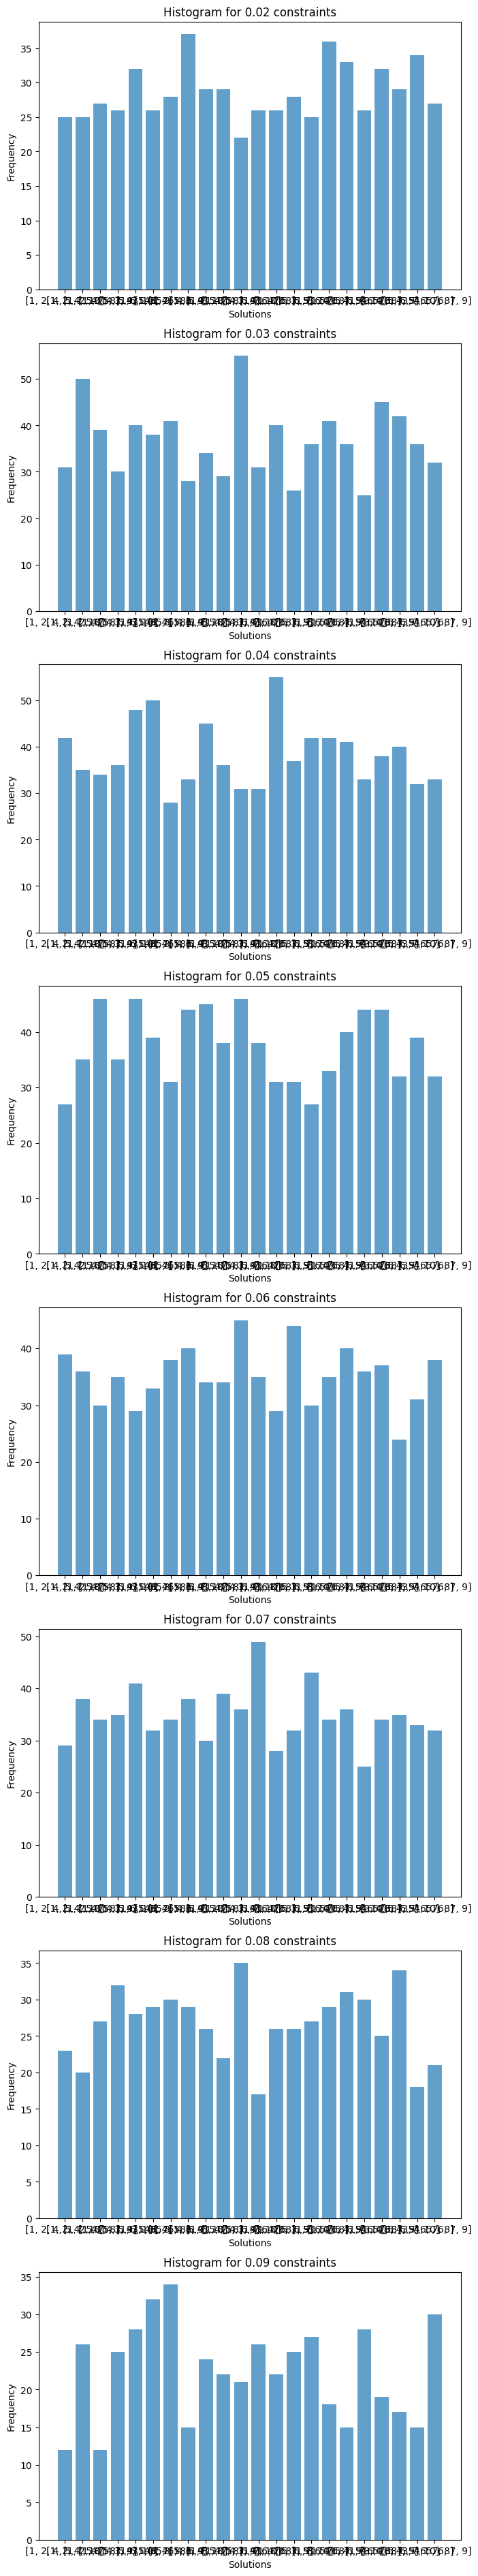

In [14]:
# @title Plot hists for lambda in LinMod
plot_hists(group_value_counts_linmod)

## Successful runs

In [15]:
def successful_runs(df, param):

  group_zeroes = df.fillna(0).groupby(param)

  num_sols = [element['num sols'].mean() for name, element in group_zeroes]

  group = df.dropna().groupby(param)

  params = [name for name, element in group]
  total_succ_runs = [len(element) for name, element in group]
  frac_succ_runs = [element / 2200 for element in total_succ_runs]

  runs_data = pd.DataFrame({param: params, 'Successful runs': total_succ_runs, '% Successful runs': frac_succ_runs, '|Sols|': num_sols})

  return runs_data

In [16]:
successful_runs(df_xor, 's')

,s,Successful runs,% Successful runs,|Sols|
0,0,2179,0.990455,22.000000
1,1,2199,0.999545,10.939545
2,2,2176,0.989091,5.459091
3,3,2064,0.938182,2.784091
4,4,1673,0.760455,1.395909
5,5,1103,0.501364,0.690455


In [17]:
successful_runs(df_linmod, 'lambda')

,lambda,Successful runs,% Successful runs,|Sols|
0,0.02,628,0.285455,0.460478
1,0.03,805,0.365909,0.644091
2,0.04,842,0.382727,0.906364
3,0.05,823,0.374091,1.115455
4,0.06,772,0.350909,1.324091
5,0.07,767,0.348636,1.451364
6,0.08,585,0.265909,1.805909
7,0.09,493,0.224091,2.015455


In [18]:
successful_runs(df_linmod_adj, 'lambda')

,lambda,Successful runs,% Successful runs,|Sols|
0,0.02,803,0.365000,0.460478
1,0.03,1089,0.495000,0.644091
2,0.04,1345,0.611364,0.906364
3,0.05,1502,0.682727,1.115455
4,0.06,1643,0.746818,1.324091
5,0.07,1730,0.786364,1.451364
6,0.08,1843,0.837727,1.805909
7,0.09,1897,0.862273,2.015455


## Uniformity

In [19]:
tests = [chi2_test, freeman_tukey_test, ks_test, anderson_darling_test, cramer_von_mises_test, watson_test]

In [20]:
p_vals_list_xor = get_p_values(sample_size=220, iterations=1000, k=22, tests=tests, param='s', df=df_xor.dropna())

significant_p_vals_xor = pd.DataFrame(columns = [t.__name__ for t in tests])
for i, test in enumerate(tests):
  significant_p_vals_xor[test.__name__] = p_vals_list_xor[i].sum() / p_vals_list_xor[i].count()

significant_p_vals_xor

,chi2_test,freeman_tukey_test,ks_test,anderson_darling_test,cramer_von_mises_test,watson_test
0,0.045,0.036,0.664,0.052,0.047,0.042
1,0.036,0.046,0.700,0.054,0.048,0.052
2,0.037,0.048,0.639,0.045,0.047,0.040
3,0.049,0.059,0.669,0.046,0.040,0.050
4,0.026,0.032,0.711,0.054,0.052,0.060
5,0.048,0.050,0.587,0.033,0.032,0.039


In [21]:
p_vals_list_linmod = get_p_values(sample_size=220, iterations=1000, k=22, tests=tests, param='lambda', df=df_linmod)

significant_p_vals_linmod = pd.DataFrame(columns = [t.__name__ for t in tests])
for i, test in enumerate(tests):
  significant_p_vals_linmod[test.__name__] = p_vals_list_linmod[i].sum() / p_vals_list_linmod[i].count()

significant_p_vals_linmod

,chi2_test,freeman_tukey_test,ks_test,anderson_darling_test,cramer_von_mises_test,watson_test
0.02,0.007,0.005,0.809,0.034,0.030,0.011
0.03,0.122,0.100,0.518,0.031,0.028,0.019
0.04,0.070,0.065,0.595,0.027,0.024,0.025
0.05,0.042,0.046,0.640,0.032,0.035,0.038
0.06,0.017,0.021,0.746,0.019,0.020,0.013
0.07,0.022,0.024,0.705,0.018,0.018,0.024
0.08,0.028,0.036,0.693,0.019,0.017,0.013
0.09,0.279,0.308,0.305,0.030,0.025,0.107


In [22]:
p_vals_list_linmod_adj = get_p_values(sample_size=220, iterations=1000, k=22, tests=tests, param='lambda', df=df_linmod_adj)

significant_p_vals_linmod_adj = pd.DataFrame(columns = [t.__name__ for t in tests])
for i, test in enumerate(tests):
  significant_p_vals_linmod_adj[test.__name__] = p_vals_list_linmod_adj[i].sum() / p_vals_list_linmod_adj[i].count()

significant_p_vals_linmod_adj

,chi2_test,freeman_tukey_test,ks_test,anderson_darling_test,cramer_von_mises_test,watson_test
0.02,0.028,0.022,0.748,0.019,0.020,0.017
0.03,0.122,0.106,0.502,0.041,0.033,0.032
0.04,0.030,0.032,0.676,0.038,0.037,0.039
0.05,0.063,0.068,0.617,0.047,0.044,0.049
0.06,0.080,0.077,0.579,0.096,0.089,0.054
0.07,0.039,0.046,0.698,0.045,0.046,0.030
0.08,0.049,0.057,0.608,0.019,0.019,0.027
0.09,0.050,0.048,0.675,0.038,0.036,0.029


We will omit the KS test as it is clearly not suitable for our data.